<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Plot-parameters" data-toc-modified-id="Plot-parameters-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Plot parameters</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#Exploration" data-toc-modified-id="Exploration-0.2.1"><span class="toc-item-num">0.2.1&nbsp;&nbsp;</span>Exploration</a></span><ul class="toc-item"><li><span><a href="#Sigma-sweep" data-toc-modified-id="Sigma-sweep-0.2.1.1"><span class="toc-item-num">0.2.1.1&nbsp;&nbsp;</span>Sigma sweep</a></span></li><li><span><a href="#Process-subsequences" data-toc-modified-id="Process-subsequences-0.2.1.2"><span class="toc-item-num">0.2.1.2&nbsp;&nbsp;</span>Process subsequences</a></span></li><li><span><a href="#Plot-mean-success" data-toc-modified-id="Plot-mean-success-0.2.1.3"><span class="toc-item-num">0.2.1.3&nbsp;&nbsp;</span>Plot mean success</a></span></li><li><span><a href="#Plot-std" data-toc-modified-id="Plot-std-0.2.1.4"><span class="toc-item-num">0.2.1.4&nbsp;&nbsp;</span>Plot std</a></span></li><li><span><a href="#Plot-persistent-time" data-toc-modified-id="Plot-persistent-time-0.2.1.5"><span class="toc-item-num">0.2.1.5&nbsp;&nbsp;</span>Plot persistent time</a></span></li><li><span><a href="#Plot-position-of-failure" data-toc-modified-id="Plot-position-of-failure-0.2.1.6"><span class="toc-item-num">0.2.1.6&nbsp;&nbsp;</span>Plot position of failure</a></span></li><li><span><a href="#Plot-failure-types" data-toc-modified-id="Plot-failure-types-0.2.1.7"><span class="toc-item-num">0.2.1.7&nbsp;&nbsp;</span>Plot failure types</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Hypercolumns-and-scaling" data-toc-modified-id="Hypercolumns-and-scaling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Hypercolumns and scaling</a></span><ul class="toc-item"><li><span><a href="#An-exploratory-example" data-toc-modified-id="An-exploratory-example-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>An exploratory example</a></span></li><li><span><a href="#Systematic" data-toc-modified-id="Systematic-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Systematic</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Symmetric" data-toc-modified-id="Symmetric-1.2.0.1"><span class="toc-item-num">1.2.0.1&nbsp;&nbsp;</span>Symmetric</a></span></li><li><span><a href="#Middle-assymetry" data-toc-modified-id="Middle-assymetry-1.2.0.2"><span class="toc-item-num">1.2.0.2&nbsp;&nbsp;</span>Middle assymetry</a></span></li><li><span><a href="#With-more-assymetry" data-toc-modified-id="With-more-assymetry-1.2.0.3"><span class="toc-item-num">1.2.0.3&nbsp;&nbsp;</span>With more assymetry</a></span></li></ul></li></ul></li></ul></li></ul></div>

# Preamble

In [80]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

np.set_printoptions(suppress=True, precision=5)

from network import Protocol, NetworkManager, Network
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

epsilon = 10e-80
vmin = -3.0

## Plot parameters

In [81]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 12.0)
sns.set(font_scale=2.5)

lw = 8
ms = 15
alpha_graph = 0.3
colors = sns.color_palette()

## Functions

### Exploration

#### Sigma sweep

In [85]:
def run_sigma_sweep(sigma_number, samples, sigma_max, manager, T_persistence=0.050):

    manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence)
    tau_s = manager.nn.tau_s
    T_recall = T_persistence * minicolumns
    T_cue = 3 * tau_s
    I_cue = 0
    nr = manager.canonical_network_representation
    diff_rest = manager.nn.w[3, 2] - manager.nn.w[4, 2]
    diff_next = manager.nn.w[2, 2] - manager.nn.w[3, 2]

    sigma_vector = np.linspace(0, sigma_max, num=sigma_number)
    sigma_normalized = sigma_vector # * factor1

    successes_collection = np.zeros((sigma_number, samples))
    persistent_times_collection = {index: [] for index in range(sigma_number)}
    sequence_collection = {index: [] for index in range(sigma_number)}

    for index, sigma in enumerate(sigma_normalized):
        manager.nn.sigma_in = sigma * np.sqrt(2 / tau_s)
        for sample in range(samples):
            aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=0.005, 
                                              reset=True, empty_history=True)
            success, pattern_sequence, persistent_times, timings = aux
            successes_collection[index, sample] = success
            persistent_times_collection[index].append(
                persistent_times[:n_patterns])
            sequence_collection[index].append(pattern_sequence)

    results_dictionary = {
        'manager': manager,
        'sigma_vector': sigma_vector,
        'success': successes_collection,
        'persistent times': persistent_times_collection,
        'sequences': sequence_collection,
        'T_persistence': T_persistence,
        'sigma_norm': sigma_normalized
    }

    return results_dictionary

#### Process subsequences

In [57]:
def process_sequence_statistics(results_dictionary):

    sequence_collection = results_dictionary['sequences']
    success_collection = results_dictionary['success']

    sigma_number =  len(sequence_collection)
    samples = len(sequence_collection[0])
    sequence_lengths = np.zeros((sigma_number, samples))
    failure_position = np.ones((sigma_number, samples)) * -1.0
    type_of_failures = np.ones((sigma_number, samples))

    for sigma_index in range(sigma_number):
        was_success = success_collection[sigma_index]
        sequences = sequence_collection[sigma_index]
        for sample_index, sequence in enumerate(sequences):
            sequence_lengths[sigma_index, sample_index] = len(sequence)
            # If the sequence was not succesful determine the type
            if not was_success[sample_index]:
                # If the cue failed to initilize
                if sequence[0] != 0:
                    failure_position[sigma_index, sample_index] = 0
                    type_of_failures[sigma_index, sample_index] = 0             
                else:
                # Determine the position and type of the error
                    diff = np.diff(sequence)
                    failed_where = np.where(diff != 1)[0][0]
                    type_of_failure = diff[failed_where]
                    failure_position[sigma_index, sample_index] = failed_where + 1
                    type_of_failures[sigma_index, sample_index] = type_of_failure 

    # Update the dictionary
    results_dictionary['sequence lengths'] = sequence_lengths
    results_dictionary['failure position'] =  failure_position
    results_dictionary['type of failure'] = type_of_failures
    
    # Calculate how many of each failure they are
    min_failure = int(np.min(type_of_failures))
    max_failure = int(np.max(type_of_failures))
    failure_counting = {}
    for failure_number in range(min_failure, max_failure):
        failure_counting[failure_number] = np.sum(type_of_failures == failure_number,                                                         axis=1) / samples
    
    results_dictionary['failure counting'] = failure_counting
    
    # Calculate how many units fail in some particular positions
    min_position = int(np.min(failure_position))
    max_position = int(np.max(failure_position))
    position_counting = {}
    for position_number in range(min_position, max_position):
        position_counting[position_number] = np.sum(failure_position == position_number,                                                       axis=1) / samples

    results_dictionary['position counting'] = position_counting

#### Plot mean success

In [58]:
def plot_mean_success_vs_sigma(results_dictionary, index=0, label=0, ax=None):

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    successes_collection = results_dictionary['success']
    sigma_vector = results_dictionary['sigma_vector']

    std = successes_collection.std(axis=1)
    mean_success = successes_collection.mean(axis=1)
    
    # Plot the mean
    ax.plot(sigma_vector, mean_success, 'o-', lw=lw, ms=ms, color=colors[index], label=label)
    
    # Plot sigma05
    sigma05_arg = np.where(mean_success <= 0.5)[0]
    if sigma05_arg.size > 0:
        sigma05 = sigma_vector[sigma05_arg[0]]
        ax.plot(sigma05, 0.5, '*', ms=(ms + 20), color='black')
    
    # Plot the interval
    low = mean_success - std
    low[low < 0.0] = 0.0
    high = mean_success + std
    ax.fill_between(sigma_vector, low, high, color=colors[index], alpha=alpha_graph)

    ax.axhline(0, ls='--', color='gray')
    ax.axvline(0, ls='--', color='gray')
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel('Success')
    ax.legend()

    return ax

#### Plot std 

In [59]:
def plot_std_success_vs_sigma(results_dictionary, index=0, label=0, ax=None):

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    successes_collection = results_dictionary['success']
    sigma_vector = results_dictionary['sigma_vector']
    std = successes_collection.std(axis=1)

    ax.plot(sigma_vector, std, 'o-', lw=lw, ms=ms,  color=colors[index] , label=label)
    
    ax.axhline(0, ls='--',color='gray')
    ax.axvline(0, ls='--',color='gray')
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel(r'$\sigma_{success \quad rate}$')
    ax.legend()

    return ax

#### Plot persistent time 

In [98]:
def plot_persistent_time_vs_sigma(results_dictionary, index=0, label=0, ax=None):


    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    persistent_times = results_dictionary['persistent times'] 
    sigma_vector = results_dictionary['sigma_vector']
    T_persistence = results_dictionary['T_persistence']
    mean_persistent = np.zeros(sigma_vector.size)
    std = np.zeros(sigma_vector.size)
    for sigma_index in range(sigma_vector.size):
        flatted = [item for l in persistent_times[sigma_index] for item in l[1:-1]]
        mean_persistent[sigma_index] = np.mean(flatted)
        std[sigma_index] = np.std(flatted)

    ax.plot(sigma_vector, mean_persistent, 'o-', lw=lw, ms=ms, color=colors[index] , label=label)
    low = mean_persistent - std
    low[low < 0.0] = 0.0
    high = mean_persistent + std
    ax.fill_between(sigma_vector, low, high, color=colors[index], alpha=alpha_graph)

    ax.axhline(T_persistence, ls='--', color=colors[index])

    ax.axhline(0, ls='--',color='gray')
    ax.axvline(0, ls='--',color='gray')
    ax.axhline(0.009, ls='--', color='red')
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel(r'$T_{persistence}$')
    ax.legend()
    
    return ax

#### Plot position of failure

In [103]:
def plot_position_failure(results_dictionary, ax=None, title =' '):

    sigma_vector = results_dictionary['sigma_vector']
    position_counting = results_dictionary['position counting']
    colors = sns.color_palette(n_colors=len(position_counting))

    if ax is None:   
        fig = plt.figure()
        ax = fig.add_subplot(111)

    for index, position in enumerate(position_counting.keys()):
        ax.plot(sigma_vector, position_counting[position], 'o-', ms=ms, lw=lw, color=colors[index],
                label=str(position))

    ax.set_ylabel(r'$\%$ of total')
    ax.set_xlabel(r'$\sigma$')
    ax.set_title('Position of failure ' + title)

    ax.axhline(0, ls='--',color='gray')
    ax.axvline(0, ls='--',color='gray')
    ax.legend()
    
    return ax

#### Plot failure types

In [104]:
def plot_failure_types(results_dictionary, ax=None, title=' '):

    lw = 8
    ms = 15
    alpha = 0.3
    sigma_vector = results_dictionary['sigma_vector']
    failure_counting = results_dictionary['failure counting']
    colors = sns.color_palette(n_colors = len(failure_counting))

    
    if ax is None:   
        fig = plt.figure()
        ax = fig.add_subplot(111)

    for index, failure_type in enumerate(failure_counting.keys()):
        ax.plot(sigma_vector, failure_counting[failure_type], 'o-', ms=ms, lw=lw, 
                color=colors[index], label=str(failure_type))

    ax.set_ylabel(r'$\%$ of total')
    ax.set_xlabel(r'$\sigma$')
    ax.set_title('Types of failures ' + title)

    ax.axhline(0, ls='--',color='gray')
    ax.axvline(0, ls='--',color='gray')
    ax.legend()
    
    return ax

# Hypercolumns and scaling
Here we try to answer the question of why the system becomes less robust when we increas the number of hpypercolums.

## An exploratory example

success 0.0
$\Delta w_{next}$ 0.5964857895022893
$\Delta w_{rest}$ 1.7728766960431588
persistent times [0.028, 0.009000000000000001, 0.025, 0.051000000000000004, 0.026000000000000002, 0.042, 0.014, 0.016]
patern sequence [0, 3, 4, 3, 4, 3]


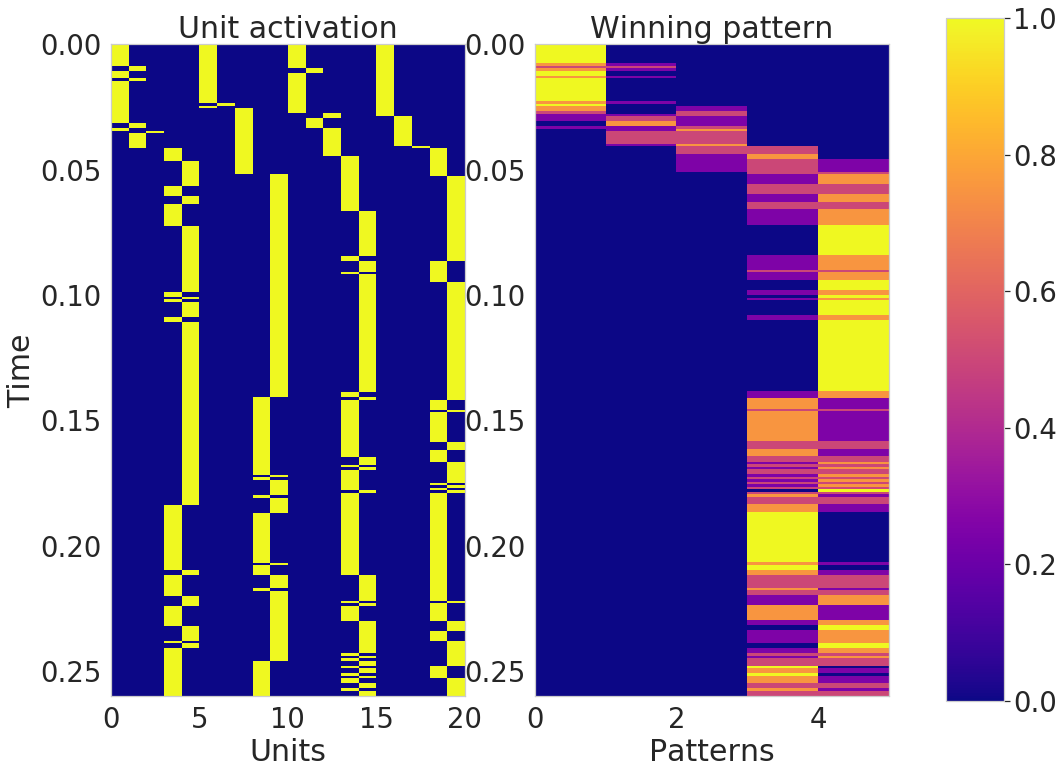

In [123]:
strict_maximum = True

g_a = 1.0
g_I = 2.0
tau_a = 0.250
G = 1.0
sigma_out = 10.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 4
minicolumns = 5
n_patterns = minicolumns

# Training protocol
training_time_base = 0.100
training_times = [training_time_base for i in range(n_patterns)]
inter_pulse_interval_base = 0.0
inter_pulse_intervals = [inter_pulse_interval_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 2.0
epochs = 1
T_persistence = 0.050

# Manager properties
dt = 0.001
values_to_save = ['o', 's']


# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
             tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
             strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation[:n_patterns],
                                        minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals, inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)

manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence)
T_recall = T_persistence * minicolumns
T_cue = tau_s
I_cue = 0
nr = manager.canonical_network_representation
aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=0.009, reset=True, empty_history=True)
success, pattern_sequence, persistent_times, timings = aux
print('success', success)
print(r'$\Delta w_{next}$', nn.w[1, 1] - nn.w[2, 1])
print(r'$\Delta w_{rest}$',nn.w[2, 1] - nn.w[3, 1])
print('persistent times', persistent_times)
print('patern sequence', pattern_sequence)
plot_network_activity_angle(manager)

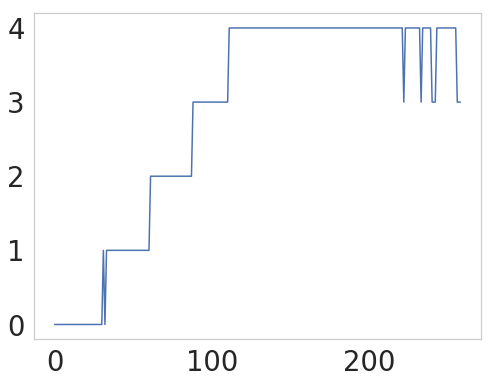

In [47]:
from analysis_functions import calculate_angle_from_history, calculate_winning_pattern_from_distances
distances = calculate_angle_from_history(manager)
winning = calculate_winning_pattern_from_distances(distances)
plt.plot(winning)

In [36]:
print('persistent times', persistent_times)
print('patern sequence', pattern_sequence)

persistent times [0.017, 0.025, 0.023, 0.017, 0.098, 0.045, 0.011]
patern sequence [0, 1, 2, 3, 4, 3]


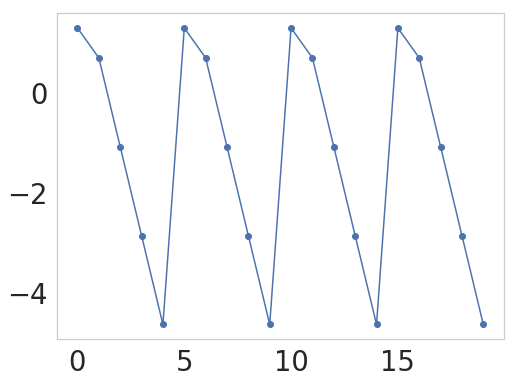

In [43]:
plt.plot(nn.w[:, 0], 'o-')

## Systematic

#### Symmetric

In [99]:
%%time
strict_maximum = True

g_a = 1.0
g_I = 10.0
tau_a = 0.250
G = 1.0
sigma_out = 6.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 4
minicolumns = 5
n_patterns = minicolumns

# Training protocol
training_time_base = 0.100
training_times = [training_time_base for i in range(n_patterns)]
inter_pulse_interval_base = 0.0
inter_pulse_intervals = [inter_pulse_interval_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 2.0
epochs = 1
T_persistence = 0.050

# Manager properties
dt = 0.001
values_to_save = ['o']

hypercolumns_set = [1, 10, 100]
results_dictionary_collection_hypercolumns = {}
sigma_number = 50
samples = 100
sigma_max = 30

for hypercolumns in hypercolumns_set:
    # Neural Network
    print(hypercolumns)
    nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    # Build the representation
    representation = PatternsRepresentation(manager.canonical_activity_representation[:n_patterns],
                                            minicolumns=minicolumns)

    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals, inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)
    results_dictionary = run_sigma_sweep(sigma_number, samples, sigma_max, manager, T_persistence=T_persistence)

    process_sequence_statistics(results_dictionary)
    results_dictionary_collection_hypercolumns[hypercolumns] = results_dictionary

1
$\Delta w_{next}$ 0.5964857895022893
$\Delta w_{rest}$ 1.7728766960431588
w_{back} -0.7636017462854596
10
$\Delta w_{next}$ 0.5964857895022893
$\Delta w_{rest}$ 1.7728766960431588
w_{back} -0.7636017462854596
100
$\Delta w_{next}$ 0.5964857895022893
$\Delta w_{rest}$ 1.7728766960431588
w_{back} -0.7636017462854596
CPU times: user 25min 31s, sys: 1min, total: 26min 32s
Wall time: 9min 24s


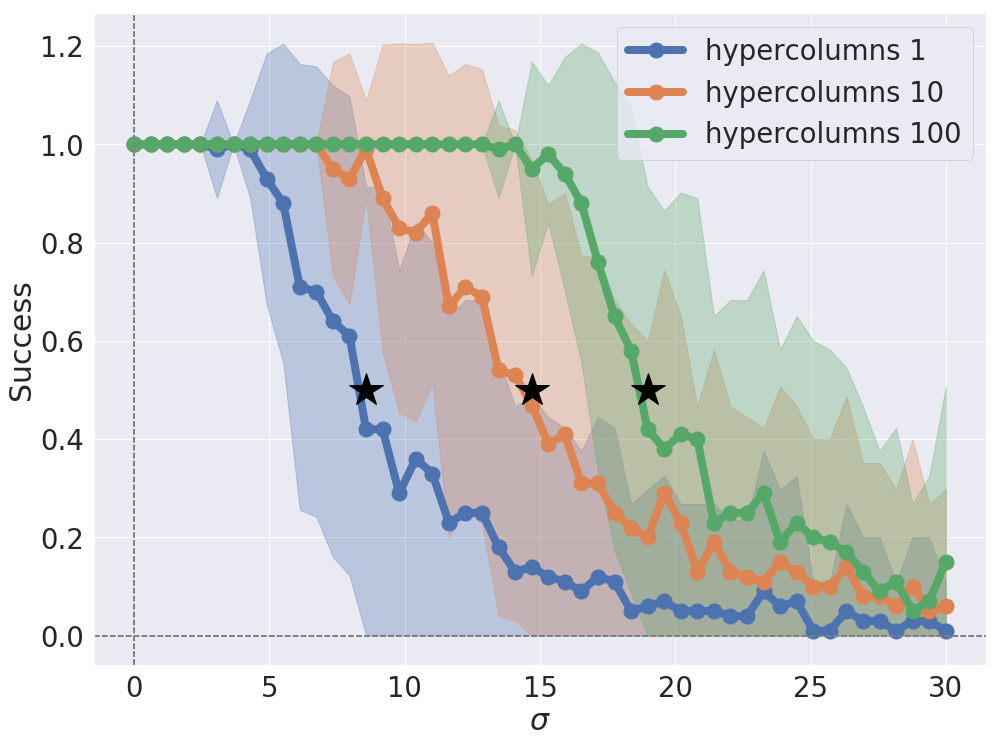

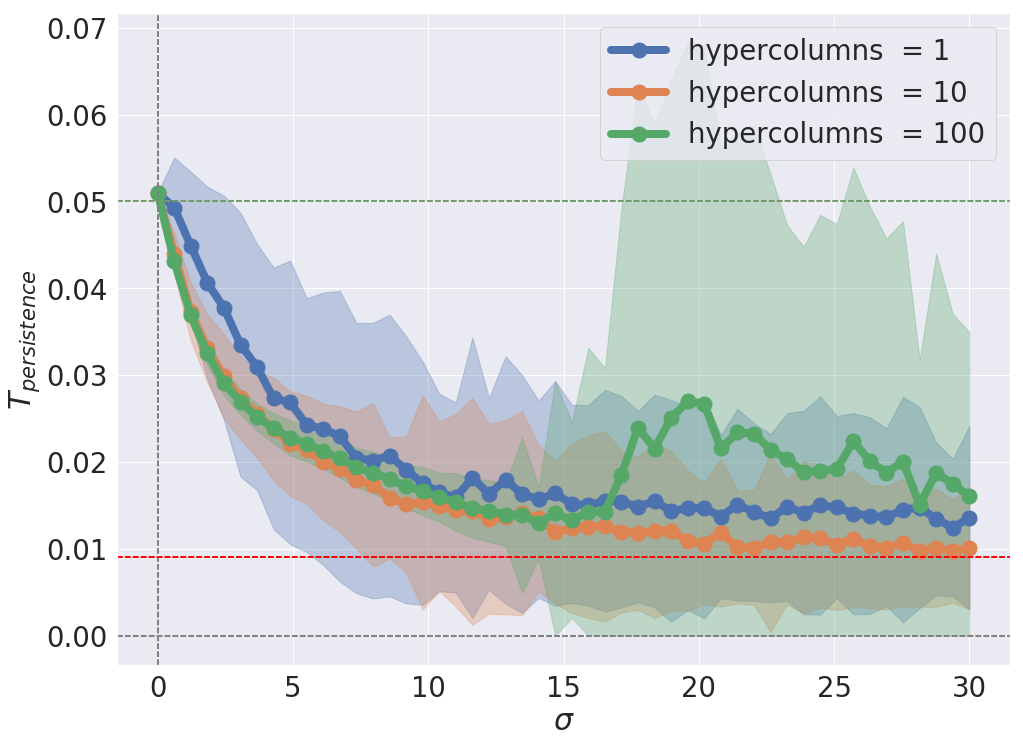

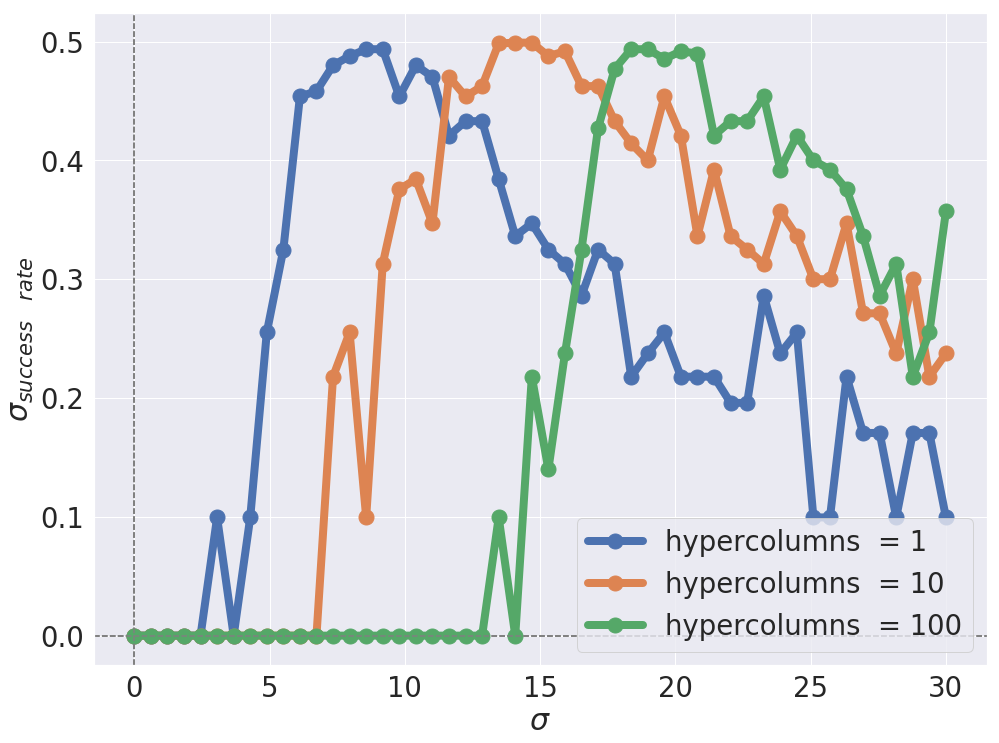

In [101]:
results_dictionary_collection = results_dictionary_collection_hypercolumns
parameter_list = hypercolumns_set
parameter_label = r'hypercolumns '
ax = None
for index, hypercolumns in enumerate(parameter_list):
    label = parameter_label + str(hypercolumns)
    results_dictionary = results_dictionary_collection[hypercolumns]
    ax = plot_mean_success_vs_sigma(results_dictionary, index=index, label=label, ax=ax)
    
ax = None
for index, parameter in enumerate(parameter_list):
    label = parameter_label + ' = ' + str(parameter)
    results_dictionary = results_dictionary_collection[parameter]
    ax = plot_persistent_time_vs_sigma(results_dictionary, index=index, label=label, ax=ax)

ax = None
for index, parameter in enumerate(parameter_list):
    label = parameter_label + ' = ' + str(parameter)
    results_dictionary = results_dictionary_collection[parameter]
    ax = plot_std_success_vs_sigma(results_dictionary, index=index, label=label, ax=ax)

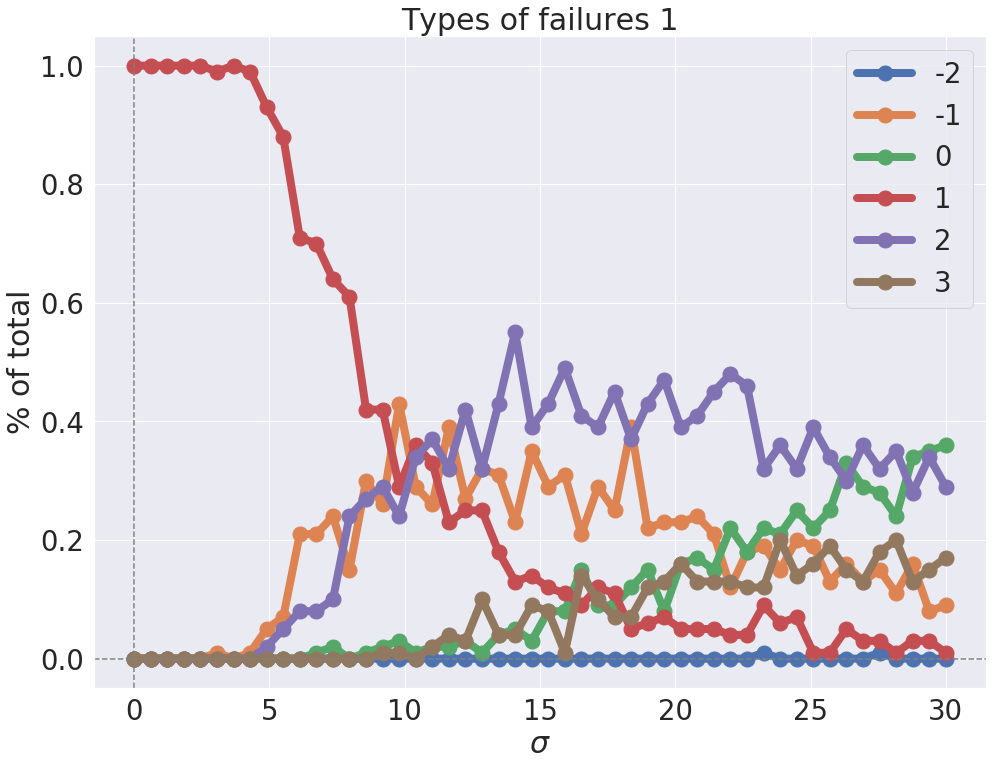

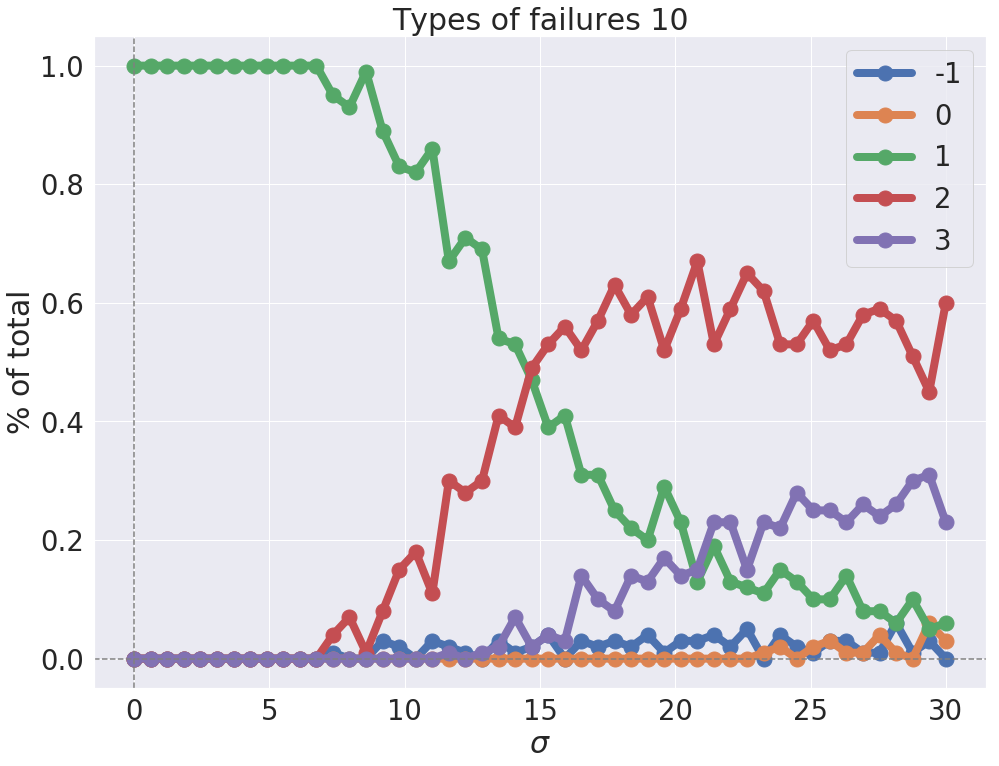

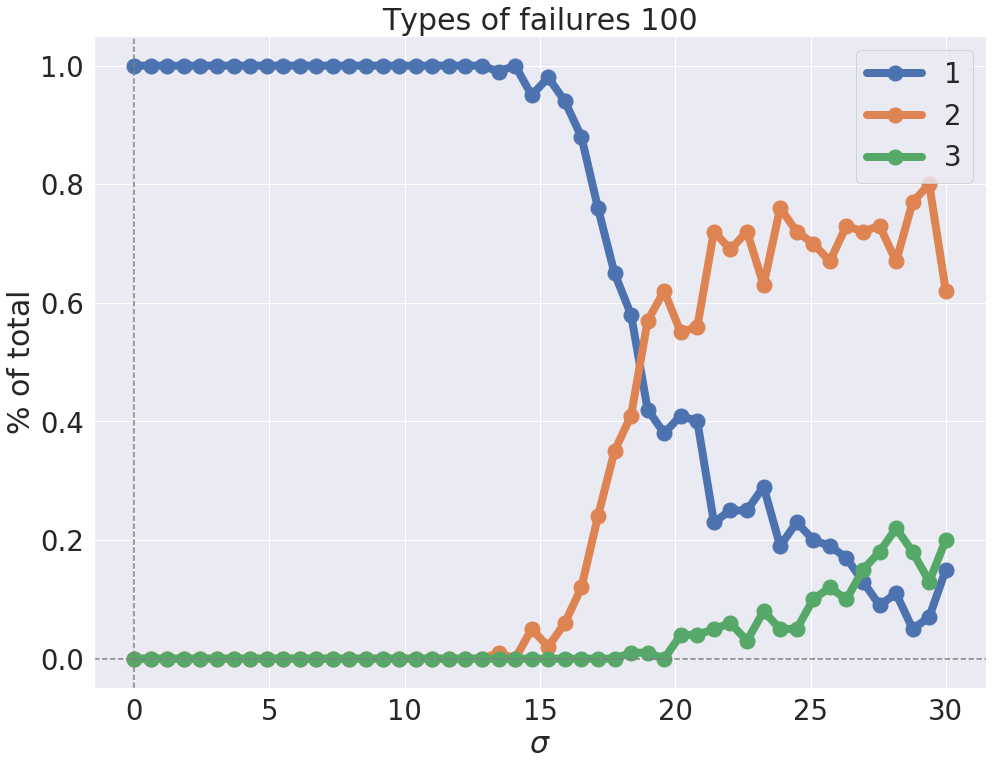

In [106]:
for hypercolumns in hypercolumns_set:
    results_dictionary = results_dictionary_collection[hypercolumns]
    plot_failure_types(results_dictionary, title=str(hypercolumns))

#### Middle assymetry

In [119]:
%%time
strict_maximum = True

g_a = 1.0
g_I = 10.0
tau_a = 0.250
G = 1.0
sigma_out = 6.0
tau_s = 0.010
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 4
minicolumns = 5
n_patterns = minicolumns

# Training protocol
training_time_base = 0.100
training_times = [training_time_base for i in range(n_patterns)]
inter_pulse_interval_base = 0.0
inter_pulse_intervals = [inter_pulse_interval_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 2.0
epochs = 1
T_persistence = 0.050

# Manager properties
dt = 0.001
values_to_save = ['o']

hypercolumns_set = [1, 10]
results_dictionary_collection_hypercolumns = {}
sigma_number = 50
samples = 100
sigma_max = 30

for hypercolumns in hypercolumns_set:
    # Neural Network
    print(hypercolumns)
    nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    # Build the representation
    representation = PatternsRepresentation(manager.canonical_activity_representation[:n_patterns],
                                            minicolumns=minicolumns)

    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals, inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)
    results_dictionary = run_sigma_sweep(sigma_number, samples, sigma_max, manager, T_persistence=T_persistence)

    process_sequence_statistics(results_dictionary)
    results_dictionary_collection_hypercolumns[hypercolumns] = results_dictionary

1
10
CPU times: user 3min 30s, sys: 120 ms, total: 3min 30s
Wall time: 3min 29s


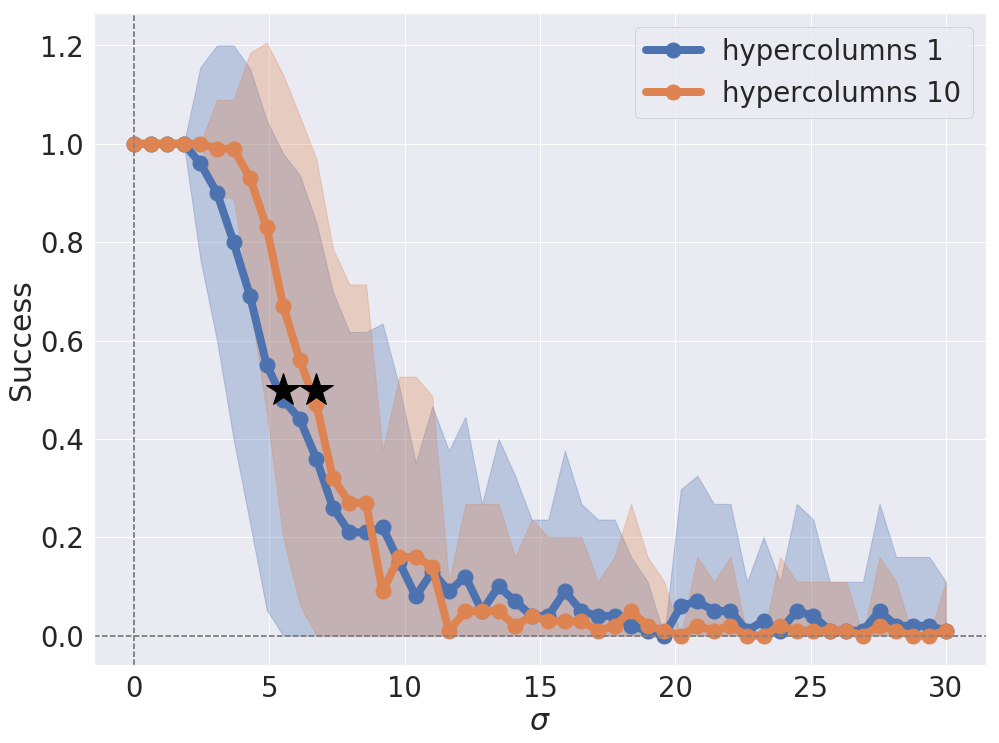

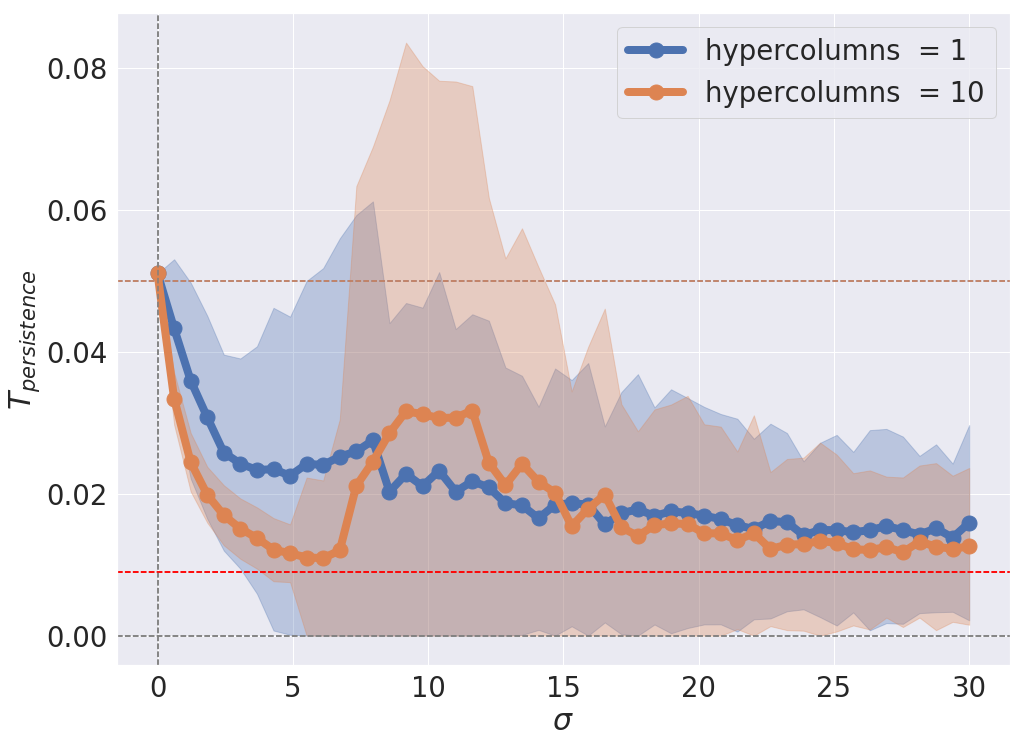

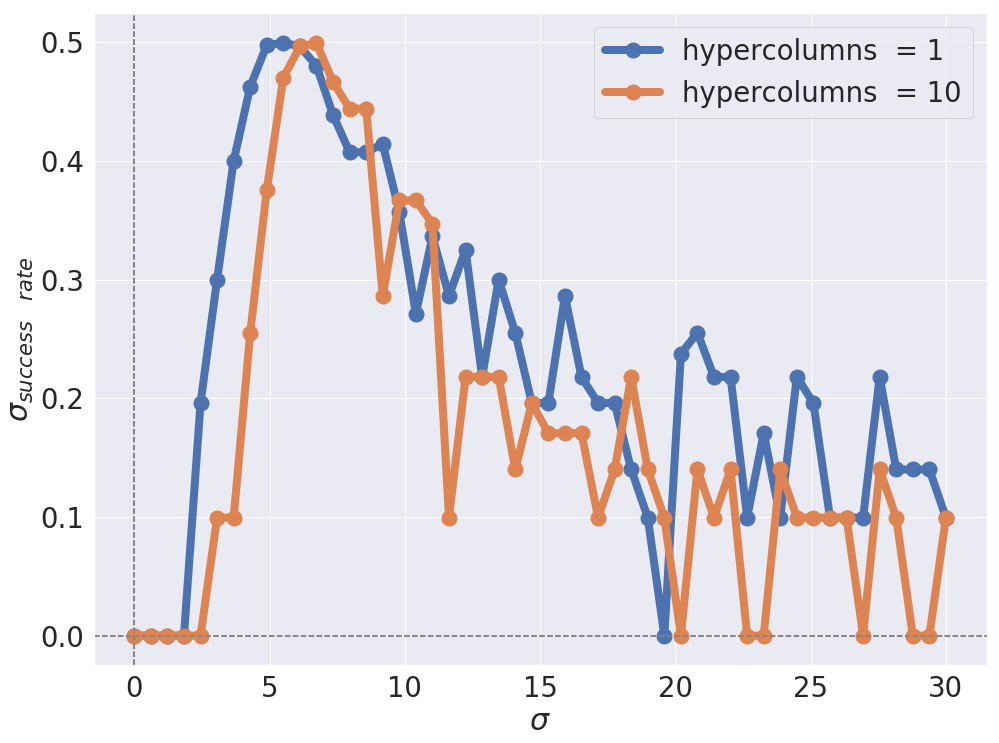

In [120]:
results_dictionary_collection = results_dictionary_collection_hypercolumns
parameter_list = hypercolumns_set
parameter_label = r'hypercolumns '
ax = None
for index, hypercolumns in enumerate(parameter_list):
    label = parameter_label + str(hypercolumns)
    results_dictionary = results_dictionary_collection[hypercolumns]
    ax = plot_mean_success_vs_sigma(results_dictionary, index=index, label=label, ax=ax)
    
ax = None
for index, parameter in enumerate(parameter_list):
    label = parameter_label + ' = ' + str(parameter)
    results_dictionary = results_dictionary_collection[parameter]
    ax = plot_persistent_time_vs_sigma(results_dictionary, index=index, label=label, ax=ax)

ax = None
for index, parameter in enumerate(parameter_list):
    label = parameter_label + ' = ' + str(parameter)
    results_dictionary = results_dictionary_collection[parameter]
    ax = plot_std_success_vs_sigma(results_dictionary, index=index, label=label, ax=ax)

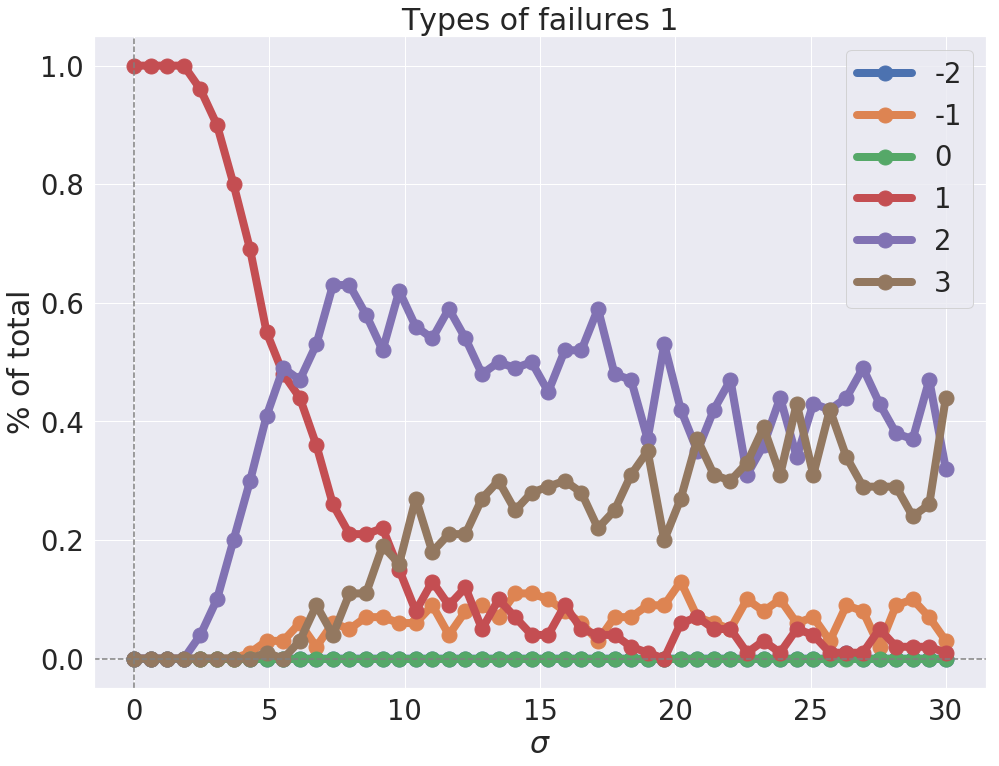

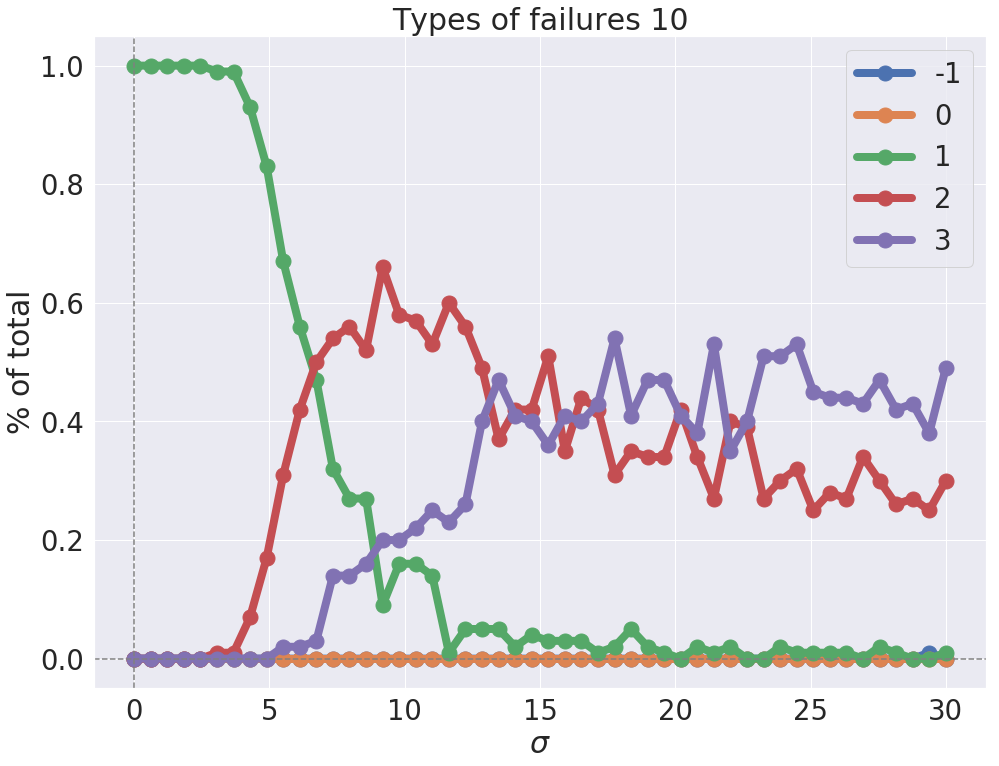

In [121]:
for hypercolumns in hypercolumns_set:
    results_dictionary = results_dictionary_collection[hypercolumns]
    plot_failure_types(results_dictionary, title=str(hypercolumns))

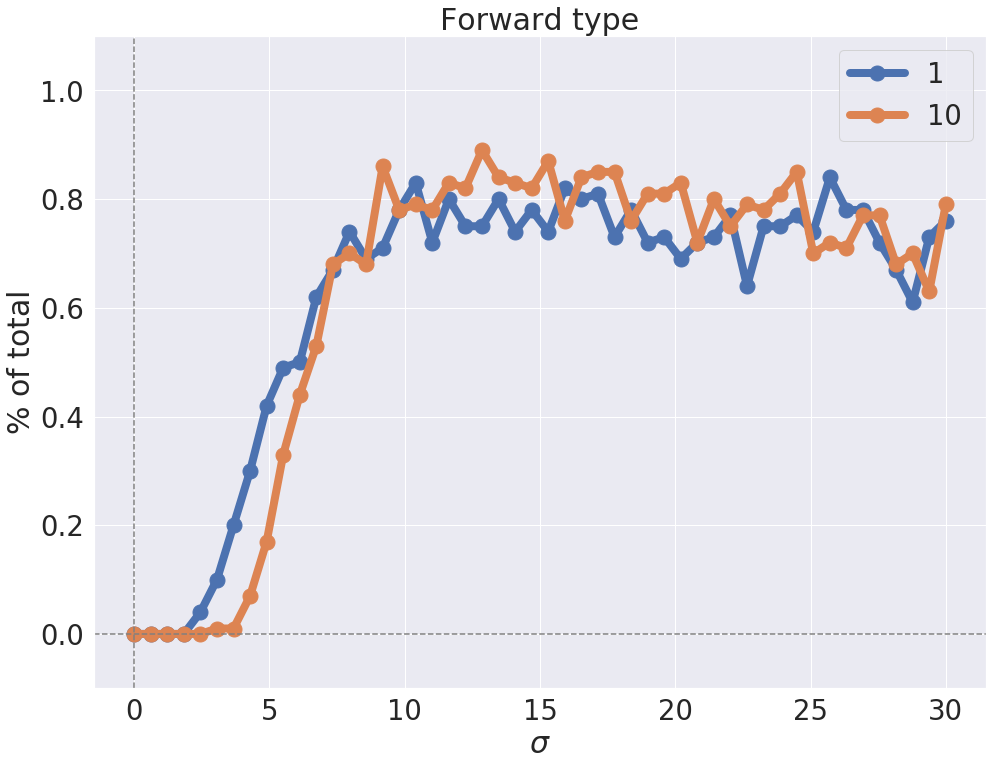

In [122]:
lw = 8
ms = 15
alpha = 0.3

fig = plt.figure()
ax = fig.add_subplot(111)

for index, hypercolumns in enumerate(hypercolumns_set):
    results_dictionary = results_dictionary_collection[hypercolumns]
    sigma_vector = results_dictionary['sigma_vector']
    failure_counting = results_dictionary['failure counting']
    colors = sns.color_palette(n_colors = len(failure_counting))
    result = failure_counting[2]  +  failure_counting[3]
    ax.plot(sigma_vector, result, 'o-', ms=ms, lw=lw, color=colors[index],
            label=str(hypercolumns))

ax.set_ylabel(r'$\%$ of total')
ax.set_xlabel(r'$\sigma$')
ax.set_title('Forward type')

ax.set_ylim([-0.1, 1.1])
ax.axhline(0, ls='--',color='gray')
ax.axvline(0, ls='--',color='gray')
ax.legend();

#### With more assymetry

In [115]:
%%time
strict_maximum = True

g_a = 1.0
g_I = 10.0
tau_a = 0.250
G = 1.0
sigma_out = 6.0
tau_s = 0.010
tau_z_pre = 0.150
tau_z_post = 0.005

hypercolumns = 4
minicolumns = 5
n_patterns = minicolumns

# Training protocol
training_time_base = 0.100
training_times = [training_time_base for i in range(n_patterns)]
inter_pulse_interval_base = 0.0
inter_pulse_intervals = [inter_pulse_interval_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 2.0
epochs = 1
T_persistence = 0.050

# Manager properties
dt = 0.001
values_to_save = ['o']

hypercolumns_set = [1, 10]
results_dictionary_collection_hypercolumns = {}
sigma_number = 50
samples = 100
sigma_max = 30

for hypercolumns in hypercolumns_set:
    # Neural Network
    print(hypercolumns)
    nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    # Build the representation
    representation = PatternsRepresentation(manager.canonical_activity_representation[:n_patterns],
                                            minicolumns=minicolumns)

    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals, inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)
    results_dictionary = run_sigma_sweep(sigma_number, samples, sigma_max, manager, T_persistence=T_persistence)

    process_sequence_statistics(results_dictionary)
    results_dictionary_collection_hypercolumns[hypercolumns] = results_dictionary

1
10
CPU times: user 3min 22s, sys: 184 ms, total: 3min 22s
Wall time: 3min 21s


/home/heberto/miniconda/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/heberto/miniconda/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/heberto/miniconda/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/heberto/miniconda/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/heberto/miniconda/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/heberto/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: 

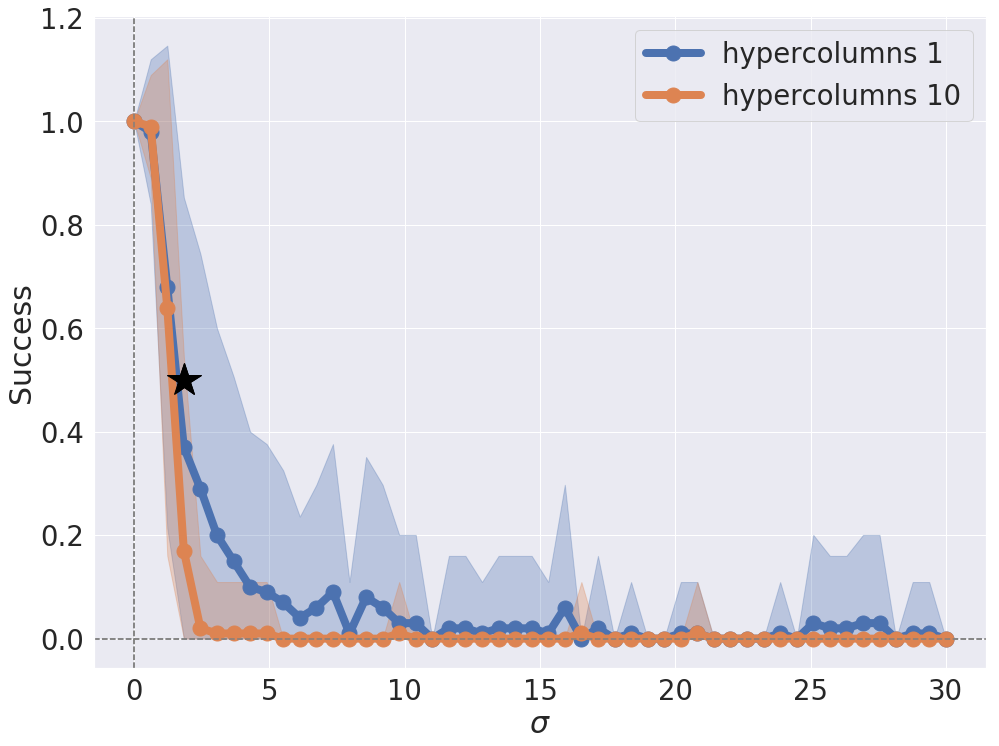

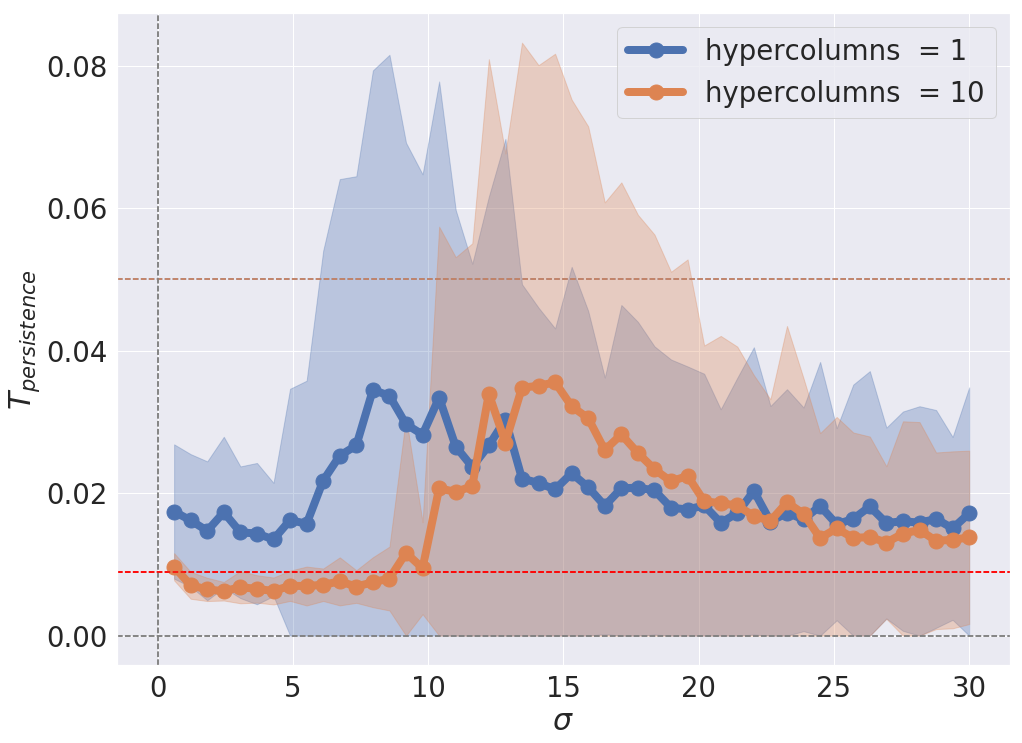

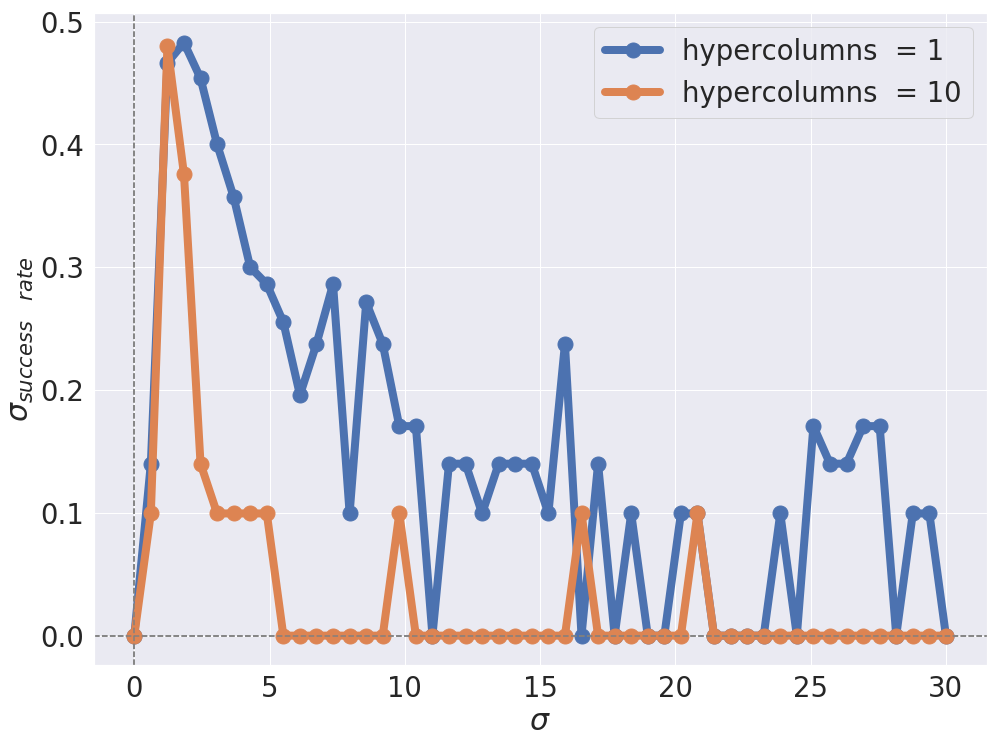

In [116]:
results_dictionary_collection = results_dictionary_collection_hypercolumns
parameter_list = hypercolumns_set
parameter_label = r'hypercolumns '
ax = None
for index, hypercolumns in enumerate(parameter_list):
    label = parameter_label + str(hypercolumns)
    results_dictionary = results_dictionary_collection[hypercolumns]
    ax = plot_mean_success_vs_sigma(results_dictionary, index=index, label=label, ax=ax)
    
ax = None
for index, parameter in enumerate(parameter_list):
    label = parameter_label + ' = ' + str(parameter)
    results_dictionary = results_dictionary_collection[parameter]
    ax = plot_persistent_time_vs_sigma(results_dictionary, index=index, label=label, ax=ax)

ax = None
for index, parameter in enumerate(parameter_list):
    label = parameter_label + ' = ' + str(parameter)
    results_dictionary = results_dictionary_collection[parameter]
    ax = plot_std_success_vs_sigma(results_dictionary, index=index, label=label, ax=ax)

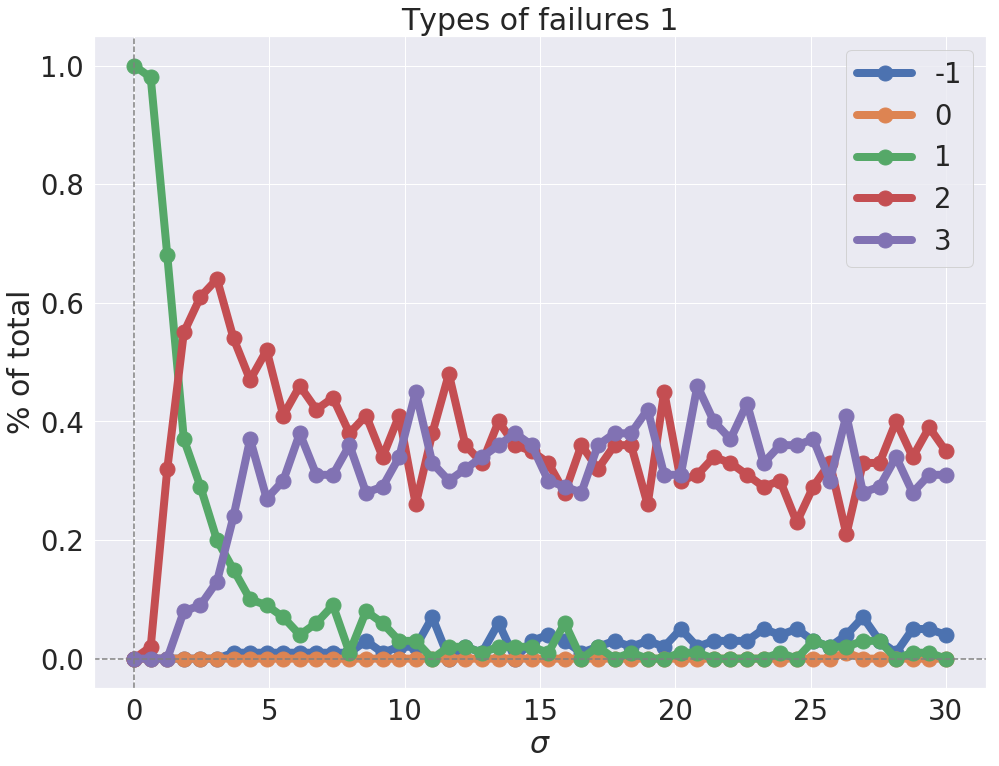

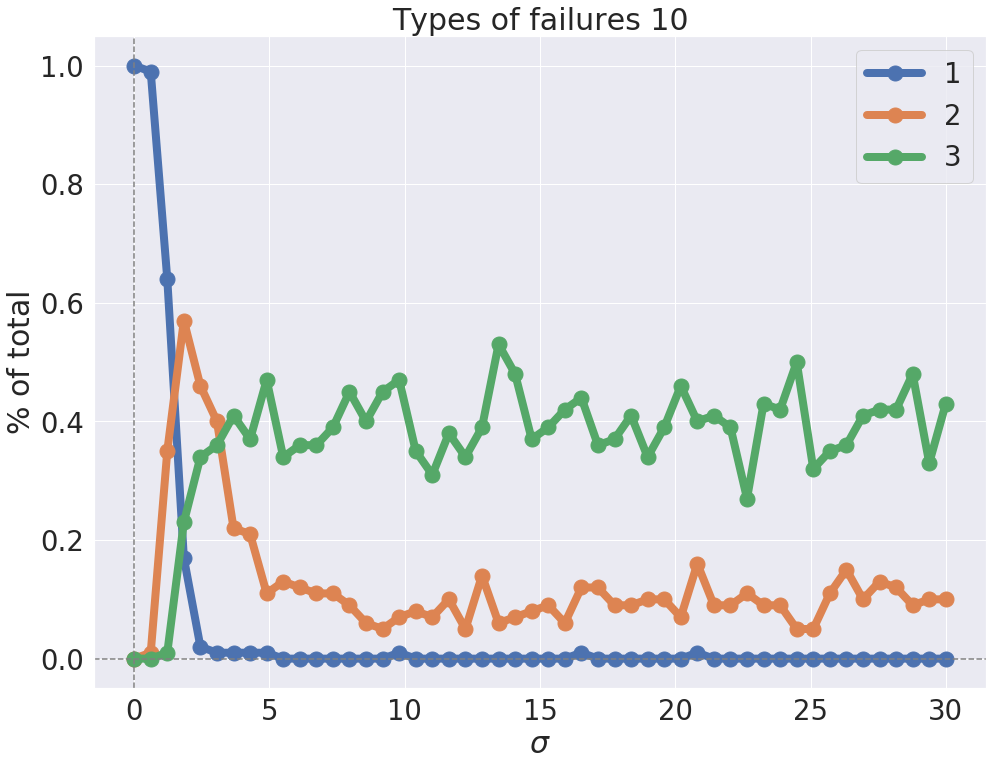

In [117]:
for hypercolumns in hypercolumns_set:
    results_dictionary = results_dictionary_collection[hypercolumns]
    plot_failure_types(results_dictionary, title=str(hypercolumns))

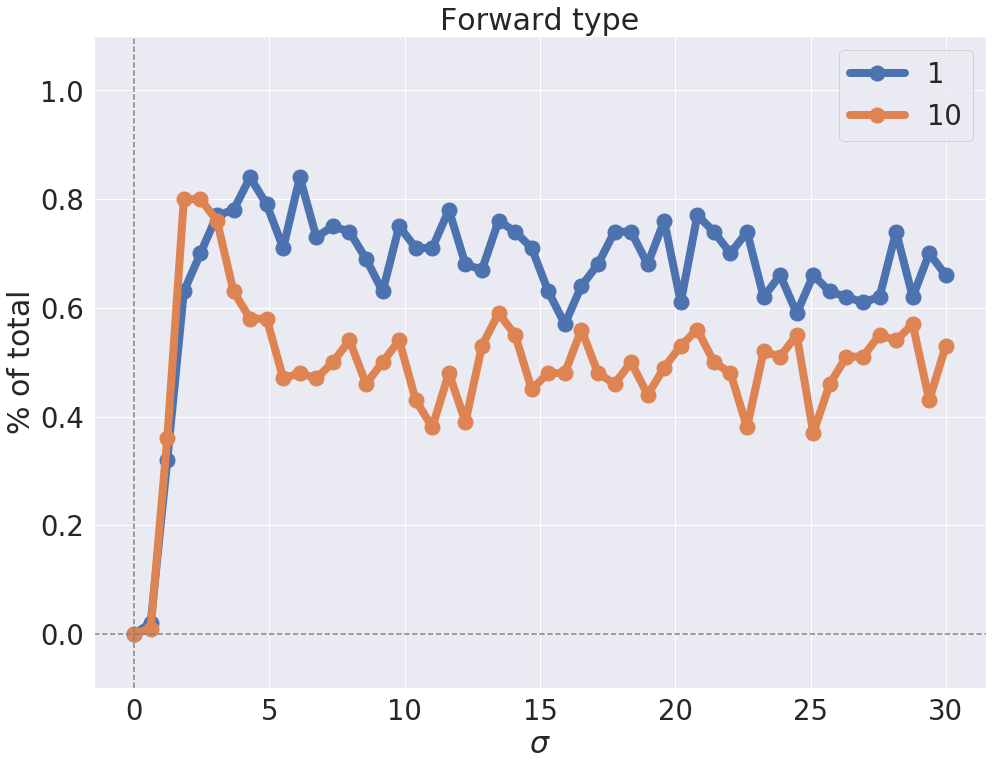

In [118]:
lw = 8
ms = 15
alpha = 0.3

fig = plt.figure()
ax = fig.add_subplot(111)

for index, hypercolumns in enumerate(hypercolumns_set):
    results_dictionary = results_dictionary_collection[hypercolumns]
    sigma_vector = results_dictionary['sigma_vector']
    failure_counting = results_dictionary['failure counting']
    colors = sns.color_palette(n_colors = len(failure_counting))
    result = failure_counting[2]  +  failure_counting[3]
    ax.plot(sigma_vector, result, 'o-', ms=ms, lw=lw, color=colors[index],
            label=str(hypercolumns))

ax.set_ylabel(r'$\%$ of total')
ax.set_xlabel(r'$\sigma$')
ax.set_title('Forward type')

ax.set_ylim([-0.1, 1.1])
ax.axhline(0, ls='--',color='gray')
ax.axvline(0, ls='--',color='gray')
ax.legend();